# SRU Beispiele
Dieses Notebook basiert auf der Anleitung von https://opendatazurich.github.io/sar-sru-api/

Wenn Sie das Notebook lokal, bzw. auf [Colab](https://colab.research.google.com/) ausführen können Sie interaktiv mit der SRU Schnittstelle des Stadtarchivs Zürich interagieren.



## Vorbereitung
Zunächst muss das Modul sruthi installiert werden, mit dem SRU Schnittstellen effizient abgefragt werden können.
Ausserdem werden einige weitere Module importiert, die für die Datenverarbeitung und Analyse hilfreich sind.

In [13]:
!pip install sruthi

In [14]:
import pandas as pd
import sruthi

## Eine Abfrage machen

In [15]:
# das ist die URL der Schnittstelle, die abgefragt werden soll
# hier können auch andere Schnittstellen abgefragt werden
# z.B. vom Staatsarchiv des Kanton Zürich: http://suche.staatsarchiv.djiktzh.ch/sru/
url = 'https://amsquery.stadt-zuerich.ch/SRU/'

# hier werden die Suchkriterien spezifiziert:
query = "isad.reference = V.B.b.43.: AND isad.descriptionlevel = Dossier"

# Abfrage der SRU Schnittstelle
records = sruthi.searchretrieve(
    url,
    query=query,
)

In [16]:
print("Die Anfrage liefert so viele Treffer:", records.count)

Die Anfrage liefert so viele Treffer: 301


Zeige den ersten Treffer. Die Ergebnisse werden als Dictionairy geliefert:

In [17]:
records[0]

{'schema': 'isad',
 'reference': 'V.B.b.43.:1.1.',
 'title': 'Geschäftsbericht des Stadtrats',
 'date': '1859',
 'descriptionlevel': 'Dossier',
 'extent': None,
 'creator': None,
 'extra': {'score': '1',
  'link': 'https://amsquery.stadt-zuerich.ch/detail.aspx?Id=549636',
  'beginDateISO': '1859-01-01',
  'beginApprox': '0',
  'endDateISO': '1859-12-31',
  'endApprox': '0',
  'hasDigitizedItems': '1'}}

# Weiterverarbeitung der Ergebnisse

## Als CSV speichern
Wenn Sie die Daten für später ablegen wollen, oder um sie mit einem anderen Programm weiterzuverarbeiten, können sie als CSV in einer Datei abgespeichert werden.


In [18]:
import csv

# Dateiname (so wird die Datei heissen. Wenn sie nicht im aktuellen Arbeitsverzeichnis abgelegt werden soll, muss hier der gesamte Dateipfad angegeben werden)
filename = 'sru_abfrage.csv'

# Erstelle CSV Writer
with open(filename, 'w',) as csvfile:
    header = ['signatur', 'titel', 'jahr', 'link_query']
    writer = csv.DictWriter(
        csvfile,
        header,
        delimiter=',',
        quotechar='"',
        lineterminator='\n',
        quoting=csv.QUOTE_MINIMAL
    )
    writer.writeheader()

    # Schleife über alle Einträge
    for record in records:
        row = {
          'signatur': record['reference'],
          'titel': record['title'],
          'jahr': record['date'],
          'link_query': record['extra']['link'],
        }
        writer.writerow(row)

## Als Pandas Dataframe speichern
Wenn Sie die Daten in Python weiterverarbeiten oder analysieren möchten, können Sie sie als Dataframe abspeichern.
In diesem Fall übernehmen wir nicht alle Informationen, sondern nur die Informationen aus den Feldern: `reference`, `title`, `date`, `link`

In [19]:
df = pd.DataFrame() # leerer Dataframe
# abfüllen der einzelnen Records als Zeilen
for record in records:
    row = {
          'signatur': [record['reference']],
          'titel': [record['title']],
          'jahr': [record['date']],
          'link_query': [record['extra']['link']],
    }
    df = df._append(pd.DataFrame(row), ignore_index=True)

Das Ergebnis sieht dann so aus.

In [20]:
df

,signatur,titel,jahr,link_query
0,V.B.b.43.:1.1.,Geschäftsbericht des Stadtrats,1859,https://amsquery.stadt-zuerich.ch/detail.aspx?...
1,V.B.b.43.:1.2.,Geschäftsbericht des Stadtrats,1860,https://amsquery.stadt-zuerich.ch/detail.aspx?...
2,V.B.b.43.:1.3.,Geschäftsbericht des Stadtrats,1861,https://amsquery.stadt-zuerich.ch/detail.aspx?...
3,V.B.b.43.:1.4.,Geschäftsbericht des Stadtrats,1862,https://amsquery.stadt-zuerich.ch/detail.aspx?...
4,V.B.b.43.:1.5.,Geschäftsbericht des Stadtrats,1863,https://amsquery.stadt-zuerich.ch/detail.aspx?...
...,...,...,...,...
296,V.B.b.43.:1.161.,Geschäftsbericht des Stadtrats,2019,https://amsquery.stadt-zuerich.ch/detail.aspx?...
297,V.B.b.43.:1.162.,Geschäftsbericht des Stadtrats,2020,https://amsquery.stadt-zuerich.ch/detail.aspx?...
298,V.B.b.43.:1.163.,Geschäftsbericht des Stadtrats,2021,https://amsquery.stadt-zuerich.ch/detail.aspx?...
299,V.B.b.43.:1.164.,Geschäftsbericht des Stadtrats,2022,https://amsquery.stadt-zuerich.ch/detail.aspx?...


## Einfache Auswertungen
Mit einem Dataframe kann man nun weitere Auswertungen machen:


Anzahl Dossiers je Titel

,count
titel,
Geschäftsbericht des Stadtrats,165
Geschäftsbericht der Zentralschulpflege,113
Geschäftsbericht der Stadtschulpflege,16
Jahresbericht der Wasserversorgung,7


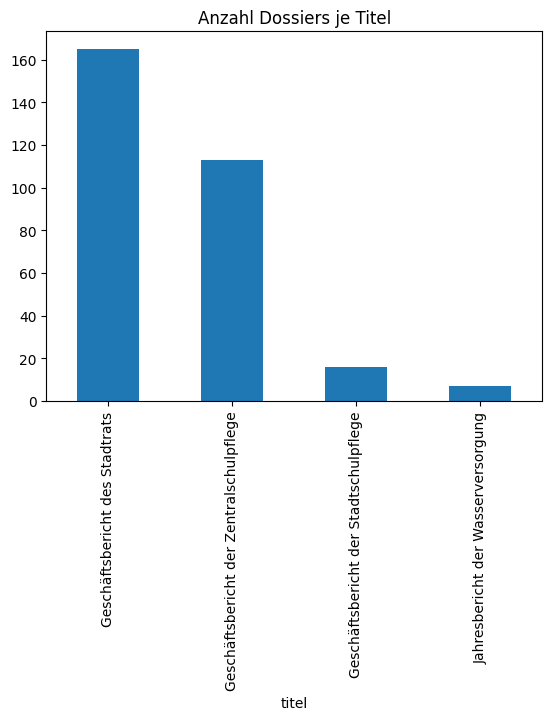

In [21]:
df['titel'].value_counts().plot(kind='bar', title='Anzahl Dossiers je Titel')
df['titel'].value_counts()

Zeitreihe nach Jahr und Berichtsart

In [22]:
# die Jahres zahlen sind nicht einheitlich formatiert. Deswegen erstellen wir eine neue Spalte, jeweils mit dem Beginn
df['jahr_beginn'] = df['jahr'].str.slice(0,4).astype(int)

In [23]:
pivot_table_count = pd.pivot_table(df, index='jahr_beginn', columns='titel', aggfunc='count')['signatur']
pivot_table_count

titel,Geschäftsbericht der Stadtschulpflege,Geschäftsbericht der Zentralschulpflege,Geschäftsbericht des Stadtrats,Jahresbericht der Wasserversorgung
jahr_beginn,,,,
1859,NaN,NaN,1.0,NaN
1860,NaN,NaN,1.0,NaN
1861,NaN,NaN,1.0,NaN
1862,NaN,NaN,1.0,NaN
1863,NaN,NaN,1.0,NaN
...,...,...,...,...
2019,NaN,NaN,1.0,NaN
2020,NaN,NaN,1.0,NaN
2021,NaN,NaN,1.0,NaN


<Axes: title={'center': 'Zeitreihe: Anzahl Dossiers je Berichtsart und Jahr'}, xlabel='jahr_beginn'>

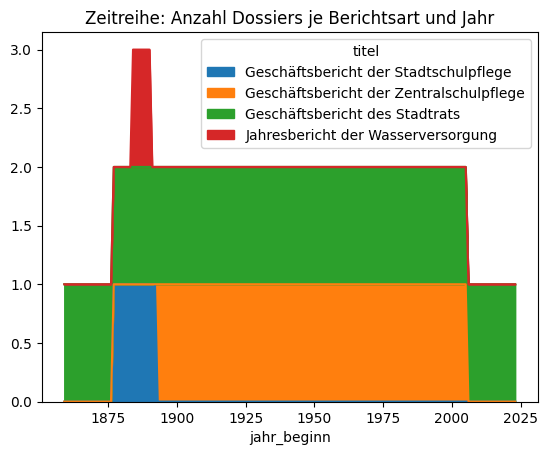

In [24]:
pivot_table_count.plot(kind='area', title='Zeitreihe: Anzahl Dossiers je Berichtsart und Jahr')

# Zusammenfassung
Sie haben nun gesehen, wie Sie:
- Abfragen formulieren und abschnicken können.
- das Ergebnis als Tabelle nutzen (als CSV oder Dataframe).
- einfache Diagramme erstellen

Nun ist es an Ihnen: Versuchen Sie eine eigene Abfrage zu machen und die Ergebnisse weiterzuverarbeiten. Sie brauchen keine Angst zu haben. In dieser Umgebung können Sie nichts kaputt machen. Versuchen Sie es einfach!